In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Test the Gaussian additive noise model with correlation

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}
[feat_viz INFO] Loaded 453 genes
[feat_viz INFO] Kept 243 genes with max expr > 0.001 
[feat_viz INFO] Kept 45 high zone genes with geom avg > 3.5 
[feat_viz INFO] Kept 64 low zone genes with geom avg < 2.5 
[feat_viz INFO] Number of original lm genes: 109
[feat_viz INFO] Number of intersecting lm genes: 97


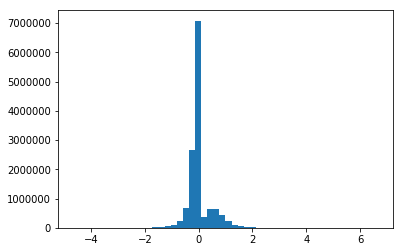

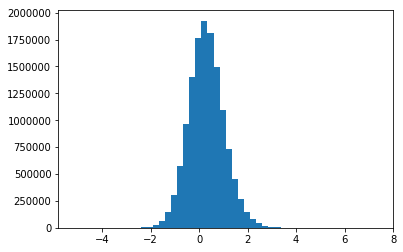

In [2]:
from intestine_info import load_processed_enterocyte_data, get_intestine_rna_lm_genes
from intestine_info import load_original_entero_zonation
from intestine_info import get_intersect_lm_genes
from sim_utils import add_correlated_noise

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
zone_vals = load_original_entero_zonation(just_vals=True)
lm_genes = get_intersect_lm_genes(var_df)
plt.hist(mtx.flatten(), bins=50)
plt.show()
noise_struct = {"model": "normal", "block_size": 200, "corr_value": 0.3}
mtx = add_correlated_noise(mtx, noise_struct, trunc=False, scale=0.6)
plt.hist(mtx.flatten(), bins=50)
plt.show()

In [3]:
from scrna_utils import get_gene_df
from main_methods import run_procedure, run_unsupervised, evaluate_result
sim_name = "test"
RDIR = os.path.join(res_dir, "entero_data", "simulations", sim_name)
os.makedirs(RDIR, exist_ok=True)
print(RDIR)

/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test


In [4]:
from scrna_utils import split_by_lm_genes
mat_a, mat_b = split_by_lm_genes(lm_genes, var_df, mtx)
def run_all_methods(mat_a, mat_b, RDIR):
    params = {
    "method": None,
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
    }
    for method in ["graph", "pc"]:
        params["method"] = method
        name = "unsup_{}".format(method)
        fn =  "lam_{}_unsupervised.plk".format(method)
        fn = os.path.join(RDIR, fn)
        result = run_unsupervised(mat_a, mat_b, params, fn=fn)
    for method in ["pc", "graph"]:
        for mtype in ["vanilla"]:
            lam_in = None
            params["method"] = method
            fn =  "result_{}_{}.plk".format(method, mtype)
            fn = os.path.join(RDIR, fn)
            result = run_procedure(mat_a, mat_b, params, lam_in=lam_in, fn=fn)
run_all_methods(mat_a, mat_b, RDIR)

[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/lam_graph_unsupervised.plk
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/lam_pc_unsupervised.plk
[feat_viz INFO] Running pc-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting pc-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_pc_vanilla.plk
[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_graph_vanilla.plk


In [5]:
from io_utils import load_all_pipeline_results
from plot_utils import plot_corr_mtx
from scipy.stats import spearmanr

pipe_res, all_lams = load_all_pipeline_results(RDIR)
# all_lams["smFISH"] = zone_vals
mopts = ["graph", "pc"]
mtypes = ["vanilla"]
corr_vec = {}
for method in mopts:
    name = 'unsup_{}'.format(method)
    corr_vec[name] = abs(spearmanr(all_lams[name], zone_vals).correlation)
    for mtype in mtypes:
        key = "{}_{}".format(method, mtype)
        result = pipe_res[key] 
        print('{} rejected {}'.format(method, len(result['rejections'])))
        for lam_t in ["lam_init", "lam_update"]:
            name = "{}_{}".format(key, lam_t)
#             all_lams[name] = result[lam_t]
            corr_vec[name] = abs(spearmanr(result[lam_t], zone_vals).correlation)
print(pd.Series(corr_vec).sort_index())

[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_pc_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_graph_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_hybrid_vanilla.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_hybrid_oracle.plk does not exist


graph rejected 5803
pc rejected 4477
graph_vanilla_lam_init      0.966201
graph_vanilla_lam_update    0.952727
pc_vanilla_lam_init         0.925297
pc_vanilla_lam_update       0.951911
unsup_graph                 0.946415
unsup_pc                    0.943627
dtype: float64


In [6]:
pipe_res

{'pc_vanilla': {'lam_init': array([ 0.91495594, -4.83461825,  7.01057246, ..., -3.67961928,
         -2.17431375,  6.33751894]),
  'lam_update': array([ -2.60441195, -14.62097208,  13.64198816, ..., -16.83456285,
         -13.57534131,  15.198955  ]),
  'p_vals': array([9.99900010e-05, 2.82971703e-02, 9.99900010e-05, ...,
         6.77732227e-01, 8.77412259e-01, 6.09939006e-03]),
  'rejections': array([   0,    2,   11, ..., 9553, 9554, 9558])},
 'graph_vanilla': {'lam_init': array([-0.0093249 , -0.02361346,  0.02581946, ..., -0.02061757,
         -0.01698743,  0.03386324]),
  'lam_update': array([-0.01338405, -0.02223444,  0.02817111, ..., -0.02139775,
         -0.02307673,  0.02082459]),
  'p_vals': array([9.99900010e-05, 9.99900010e-05, 9.48905109e-02, ...,
         4.56754325e-01, 3.23967603e-02, 2.67973203e-02]),
  'rejections': array([   0,    1,    5, ..., 9551, 9553, 9558])}}

[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_pc_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_graph_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_hybrid_vanilla.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_hybrid_oracle.plk does not exist


palantir
paga


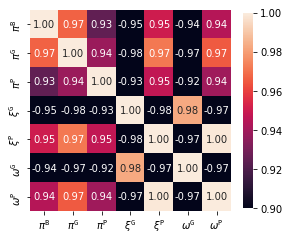

In [33]:
# add lambdas from ti methods
mdir = '/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/ti_methods'
names = ['palantir', 'paga']
for name in names:
    fn = os.path.join(mdir, '{}_obs_df.csv'.format(name))
    df = pd.read_csv(fn)
    df = df.set_index('cell_id')
    df = df.loc[obs_df['cell_id']]
    print(name)
    all_lams[name] = df['pseudotime']

lam_df = pd.DataFrame(all_lams)
# manually switch signs
switch_signs = ["graph_vanilla_lam_init", 
                "graph_vanilla_lam_update",
                "pc_vanilla_lam_update",
                "unsup_graph",
                "unsup_pc"]
for var in switch_signs:
    lam_df[var] = - lam_df[var]
# select and rename here

methods = ["smFISH", 
           "graph_vanilla_lam_init", 
           "pc_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "pc_vanilla_lam_update",
           "unsup_graph",
           "unsup_pc",
#            "palantir", 
#            "paga"
          ]
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
    "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
    "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
    "unsup_graph": r"$\omega^\mathtt{G}$",
    "unsup_pc": r"$\omega^\mathtt{P}$",
#     "palantir": r"$\omega^\mathtt{1}$",
#     "paga" : r"$\omega^\mathtt{2}$",
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
sub_df.head()
plot_corr_mtx(sub_df, vmin=0.9)

[feat_viz INFO] Running pc-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting pc-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_pc_vanilla.plk
[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/simulations/test/result_graph_vanilla.plk
